In [45]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [62]:
import torch
from torchvision import transforms, datasets
import matplotlib.pyplot as plt
from entropy_model import EntropyBottleneck
import tqdm

device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

In [47]:
transform = transforms.Compose([
                transforms.ToTensor(),
                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
                ])
invTrans = transforms.Compose([ transforms.Normalize(mean = [ 0., 0., 0. ],
                                                     std = [ 2, 2, 2 ]),
                                transforms.Normalize(mean = [ -0.5, -0.5, -0.5 ],
                                                     std = [ 1., 1., 1. ]),
                               ])

def plot_image(x_tensor):
    plt.imshow(invTrans(x_tensor).permute(1,2,0))

In [48]:
dset = datasets.SVHN(root='data/', download=True, transform=transform)

Using downloaded and verified file: data/train_32x32.mat


In [49]:
loader = torch.utils.data.DataLoader(dset, batch_size=256)
print(len(loader))

287


In [50]:
it = iter(loader)

In [51]:
x, y = next(it)

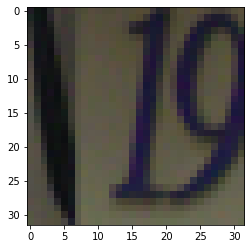

In [52]:
plot_image(x[0])

In [53]:
# define models
class AutoencoderCompressor(torch.nn.Module):
    def __init__(self, bottleneck_dim=32, img_size=(32, 32, 3), dim=16):
        super(AutoencoderCompressor, self).__init__()
        self.encoder = Encoder(img_size, dim)
        self.decoder = Decoder(img_size, dim)
        self.entropy_bottleneck = EntropyBottleneck(bottleneck_dim)
    
    def forward(self, x):
        z = self.encoder(x)
        z_tilde, likelihood = self.entropy_bottleneck(z) # use uniform noise during training, hard quantization during eval
        x_hat = self.decoder(z_tilde)
        return x_hat, likelihood

class Decoder(torch.nn.Module):
    def __init__(self, img_size, dim):
        super(Decoder, self).__init__()

        self.dim = dim
        self.img_size = img_size


        self.features_to_image = torch.nn.Sequential(
            torch.nn.ConvTranspose2d(8 * dim, 4 * dim, 4, 2, 1),
            torch.nn.ReLU(),
            torch.nn.BatchNorm2d(4 * dim),
            torch.nn.ConvTranspose2d(4 * dim, 2 * dim, 4, 2, 1),
            torch.nn.ReLU(),
            torch.nn.BatchNorm2d(2 * dim),
            torch.nn.ConvTranspose2d(2 * dim, dim, 4, 2, 1),
            torch.nn.ReLU(),
            torch.nn.BatchNorm2d(dim),
            torch.nn.ConvTranspose2d(dim, self.img_size[2], 4, 2, 1),
            torch.nn.Tanh()
        )

    def forward(self, input_data):
        return self.features_to_image(input_data)



class Encoder(torch.nn.Module):
    def __init__(self, img_size, dim):
        """
        img_size : (int, int, int)
            Height and width must be powers of 2.  E.g. (32, 32, 1) or
            (64, 128, 3). Last number indicates number of channels, e.g. 1 for
            grayscale or 3 for RGB
        """
        super(Encoder, self).__init__()

        self.img_size = img_size

        self.image_to_features = torch.nn.Sequential(
            torch.nn.Conv2d(self.img_size[2], dim, 4, 2, 1),
            torch.nn.LeakyReLU(0.2),
            torch.nn.Conv2d(dim, 2 * dim, 4, 2, 1),
            torch.nn.LeakyReLU(0.2),
            torch.nn.Conv2d(2 * dim, 4 * dim, 4, 2, 1),
            torch.nn.LeakyReLU(0.2),
            torch.nn.Conv2d(4 * dim, 8 * dim, 4, 2, 1),
            torch.nn.LeakyReLU(0.2)
        )

    def forward(self, input_data):
        x = self.image_to_features(input_data)
        return x

In [54]:
model = AutoencoderCompressor(bottleneck_dim=128)

In [55]:
x.shape

torch.Size([256, 3, 32, 32])

In [56]:
x_hat, lik = model(x)

In [57]:
x_hat.shape, lik.shape

(torch.Size([256, 3, 32, 32]), torch.Size([256, 128, 2, 2]))

In [58]:
# loss functions
def rate_loss(likelihoods):
    batch_size = likelihoods.shape[0]
    rate_batch = -torch.sum(torch.log2(likelihoods)) # total rate of batch (factorized prior)
    rate_per_sample = rate_batch / batch_size # rate per sample
    return rate_per_sample

def distortion_loss(x, x_hat):
    # SED = squared-error-distortion
    SED_batch = torch.linalg.vector_norm(x-x_hat, dim=(1,2,3))**2 # vector of SED for each element in batch
    SED_per_sample = torch.mean(SED_batch)
    return SED_per_sample

In [63]:
# training loop
def train_one_epoch(model, optimizer, loader, lmbda):
    model.train()
    
    rate_epoch, distortion_epoch = 0, 0
    for x, _ in tqdm.tqdm(loader):
        
        x = x.to(device)
        optimizer.zero_grad()  # Clear gradients.
        x_hat, likelihoods = model(x)  # Forward pass.
        rate = rate_loss(likelihoods) # compute average rate
        # rate = -torch.sum(torch.log2(likelihoods))
        distortion = distortion_loss(x, x_hat) # compute average distortion
        RD_loss = rate + lmbda * distortion
        RD_loss.backward()  # Backward pass.
        optimizer.step()  # Update model parameters.

        rate_epoch += rate.item()
        distortion_epoch += distortion.item()

    return rate_epoch / len(loader), distortion_epoch / len(loader)


@torch.no_grad()
def test(model, loader):
    model.eval()

    total_correct = 0
    for data in loader:
        data.cuda()
        logits = model(data.pos, data.batch)
        pred = logits.argmax(dim=-1)
        total_correct += int((pred == data.y).sum())

    return total_correct / len(loader.dataset)

In [64]:
model = AutoencoderCompressor(bottleneck_dim=128).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

In [65]:
for epoch in range(1, 51):
    r, d = train_one_epoch(model, optimizer, loader, lmbda=1.)
    # test_acc = test(model, test_loader)
    print(f'Epoch: {epoch:02d}, rate: {r:.4f} bps, distortion: {d:.4f}')

100%|██████████| 287/287 [00:24<00:00, 11.91it/s]


Epoch: 01, rate: 1857.8628, distortion: 168.0927


100%|██████████| 287/287 [00:23<00:00, 12.25it/s]


Epoch: 02, rate: 802.9458, distortion: 84.3070


100%|██████████| 287/287 [00:23<00:00, 12.33it/s]


Epoch: 03, rate: 377.0806, distortion: 81.1559


  4%|▍         | 12/287 [00:00<00:21, 12.53it/s]